1. Find differentially expressed receptors on fibroblasts 1v1 not 1vAll
2. Ligand expression on epithelial cell populations
3. Fisher's exact test for receptor-ligand odds

In [1]:
%load_ext autoreload
%autoreload 2

import scanpy as sc
import numpy as np
import pandas as pd
import itertools

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import scrna

/home/ing/miniconda3/envs/scrna/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
from scipy.stats import fisher_exact

In [3]:
import pickle
RL = pickle.load(open("cabello_aguilar_dict.pkl", "rb"))
all_ligands = []
for k, v in RL.items():
    for l in v:
        if l not in all_ligands: 
            all_ligands.append(l)

# 1. Fibroblast receptors

In [4]:
scores = sc.read_h5ad("receptor_genelists_2020_06_30_scores.h5ad")
print(scores.shape)

scores

(67988, 675)


AnnData object with n_obs × n_vars = 67988 × 675
    obs: 'batch', 'batch_num', 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'percent_mito', 'nCount_HASH', 'nFeature_HASH', 'sampleID', 'HASH_maxID', 'HASH_secondID', 'HASH_margin', 'HASH_classification', 'HASH_classification_global', 'hash_ID', 'Patient_Rep', 'Patient', 'cohort', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'n_genes', 'scVI_vanilla_leiden', 'CellType_v1', 'SubType_v1', 'BroadCellType', 'KRT_group', 'KRT_group_subtype', 'SubType_v2'

In [5]:
gex = sc.read_h5ad("../BladderGEX_run2_working.h5ad")
gex = gex[:, gex.var_names.isin(all_ligands)]
print(gex.shape)
gex

(67988, 796)


View of AnnData object with n_obs × n_vars = 67988 × 796
    obs: 'batch', 'batch_num', 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'percent_mito', 'nCount_HASH', 'nFeature_HASH', 'sampleID', 'HASH_maxID', 'HASH_secondID', 'HASH_margin', 'HASH_classification', 'HASH_classification_global', 'hash_ID', 'Patient_Rep', 'Patient', 'cohort', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'n_genes', 'scVI_vanilla_leiden', 'CellType_v1', 'SubType_v1', 'BroadCellType', 'KRT_group', 'KRT_group_subtype', 'SubType_v2'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'PREPROCESSED_FLAG', 'batch_colors', 'leiden', 'neighbors', 'preprocessing_ops', 'scVI_args'
    obsm: 'X_scVI_tsne_vanilla', 'X_scVI_umap

In [6]:
fib_idx = scores.obs['SubType_v2'].str.contains('Fibroblast')
scores = scores[fib_idx]
fib_types = np.unique(scores.obs['SubType_v2'])
print(fib_types)

print(scores.shape)

['ACTA2_Fibroblast' 'FAP_Fibroblast' 'PDGFRB_Fibroblast' 'PDPN_Fibroblast']
(2076, 675)


In [7]:
comps = []
dfs = []
top_receptors = []
for j, i in itertools.product(fib_types, fib_types):
    if j==i: continue
    if f'{j}_{i}' in comps: continue
        
    comps.append(f'{j}_{i}')
    comps.append(f'{i}_{j}')
    
    print(j, 'vs', i)
    sub_scores = scores[scores.obs['SubType_v2'].isin([j, i])]
    sc.tl.rank_genes_groups(sub_scores, 'SubType_v2', method='wilcoxon')
    
    df_j = sc.get.rank_genes_groups_df(sub_scores, j)
    df_i = sc.get.rank_genes_groups_df(sub_scores, i)
    
    df_j['group'] = [j]*df_j.shape[0]
    df_j['vs'] = [i]*df_j.shape[0]
    
    df_i['group'] = [i]*df_i.shape[0]
    df_i['vs'] = [j]*df_i.shape[0]
    
    dfs.append(df_j)
    dfs.append(df_i)
    
    df_j = df_j.loc[df_j['pvals_adj'] < 0.01]
    df_i = df_i.loc[df_i['pvals_adj'] < 0.01]
    
    for r in list(df_j['names'].values) + list(df_j['names'].values):
        if r not in top_receptors:
            top_receptors.append(r)
    
dfs = pd.concat(dfs, axis=0)
print(dfs.shape)
dfs.index.name = 'idx'
dfs.to_csv('Fibroblasts_receptors_pairwise.csv')
print(top_receptors)

Trying to set attribute `.uns` of view, copying.


ACTA2_Fibroblast vs FAP_Fibroblast


Trying to set attribute `.uns` of view, copying.


ACTA2_Fibroblast vs PDGFRB_Fibroblast


Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


ACTA2_Fibroblast vs PDPN_Fibroblast
FAP_Fibroblast vs PDGFRB_Fibroblast
FAP_Fibroblast vs PDPN_Fibroblast


Trying to set attribute `.uns` of view, copying.


PDGFRB_Fibroblast vs PDPN_Fibroblast
(1200, 7)
['CACNA1C', 'OSMR', 'TGFBR1', 'CD44', 'MYLK', 'RAMP1', 'LINGO1', 'ITGA5', 'CNTN1', 'FAP', 'ITGA11', 'ROBO2', 'ROR2', 'ABCA1', 'NRP1', 'MCAM', 'CDH6', 'PDGFRB', 'PDE1A', 'NOTCH3', 'ENPEP', 'CSPG4', 'EDNRA', 'FLT1', 'ITGA4', 'SDC2', 'EPHA3', 'NRXN3', 'THY1', 'PLSCR4', 'ITGA1', 'PTH1R', 'RXFP1', 'PLXND1', 'PTPRG']


Warn n_cells==0 for group No_KRT_CDH12_CDH18_Epithelial


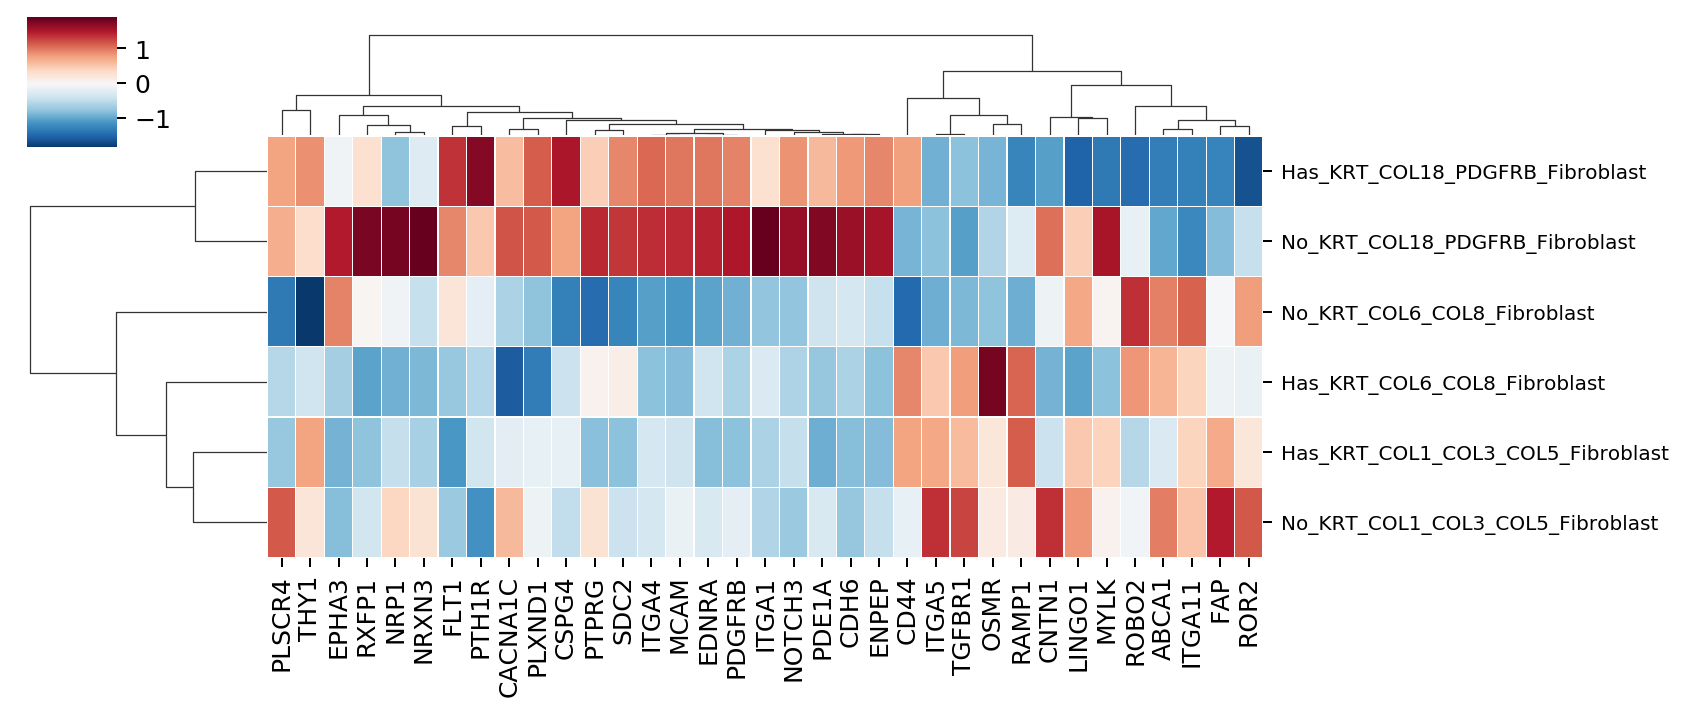

In [8]:
scrna.plot_heatmap(scores, top_receptors, groupby = 'KRT_group_subtype', 
                   transpose=False, 
                   z_score=1, cmap='RdBu_r', center_cmap=0,
                   log=False,
                   figsize=(10,4))

In [9]:
matched_ligands = []
for r in top_receptors:
    ligs = RL[r]
    for l in ligs:
        if l not in matched_ligands:
            matched_ligands.append(l)
print(matched_ligands)
print(len(matched_ligands))

['CALM1', 'CALM2', 'NCAM1', 'RIMS1', 'IL31', 'OSM', 'CGN', 'GDF9', 'GNB3', 'RPS27A', 'TGFB1', 'TGFB2', 'TGFB3', 'UBA52', 'UBB', 'UBC', 'COL14A1', 'COL1A1', 'COL1A2', 'FGF1', 'FGF2', 'FN1', 'HAS2', 'HBEGF', 'HGF', 'LPL', 'MADCAM1', 'MMP1', 'MMP7', 'MMP9', 'PKM', 'PSEN1', 'SPP1', 'VCAN', 'VIM', 'CALM3', 'ADM2', 'CALCA', 'CALCB', 'IAPP', 'EFEMP2', 'KRTAP4-12', 'OMG', 'RTN4', 'ADAM15', 'ADAM17', 'ADAM23', 'ANGPT1', 'ANGPTL3', 'COL18A1', 'CTGF', 'CYR61', 'FBN1', 'FGA', 'FGB', 'FGG', 'L1CAM', 'PLAU', 'TNC', 'VEGFD', 'VTN', 'CNTN2', 'NPY', 'PYY', 'OLFM2', 'SLIT2', 'SLIT3', 'GDF5', 'WNT5A', 'LIN7C', 'PLTP', 'RIMS2', 'SHANK1', 'FGF4', 'FGF7', 'PGF', 'SEMA3A', 'SEMA3B', 'SEMA3C', 'SEMA3D', 'SEMA3E', 'SEMA3F', 'VEGFA', 'VEGFB', 'MFGE8', 'PDAP1', 'PDGFA', 'PDGFB', 'PDGFC', 'PDGFD', 'DLL1', 'JAG1', 'JAG2', 'THBS2', 'DLK1', 'DLL3', 'DLL4', 'AGT', 'C1QA', 'EDN1', 'EDN2', 'EDN3', 'GNAI2', 'LTA', 'PIGF', 'PLG', 'VEGFC', 'ADAM28', 'CD14', 'F13A1', 'ICAM4', 'MDK', 'TGM2', 'THBS1', 'VCAM1', 'ANOS1', 'APOC

In [10]:
pct = scrna.plot_heatmap(gex[gex.obs['SubType_v2'].str.contains('Epithelial')], matched_ligands, 'KRT_group_subtype', 
                         transpose=False, agg='percent', return_data=True, draw=False)
is_expressed = pct.columns.values[(pct > 0.2).sum(axis=0) > 0]
print(is_expressed)

['C1QA' 'CYR61' 'CGN' 'ADAM15' 'EFNA1' 'SEMA4A' 'C1orf112' 'LAMC1' 'TGFB2'
 'ADAM17' 'PIGF' 'RTN4' 'RPS27A' 'COL5A2' 'ADAM23' 'FN1' 'COL4A4' 'COL4A3'
 'COL6A3' 'CNTN4' 'SEMA3F' 'GNAI2' 'WNT5A' 'NLGN1' 'SLIT2' 'SPP1' 'PDGFC'
 'VEGFC' 'VCAN' 'EFNA5' 'HBEGF' 'FGF1' 'SLIT3' 'EDN1' 'VEGFA' 'RIMS1'
 'FYN' 'LAMA2' 'CTGF' 'THBS2' 'NXPH1' 'SEMA3C' 'SEMA3E' 'SEMA3A' 'SEMA3D'
 'COL1A2' 'PDAP1' 'LAMB1' 'ANOS1' 'COL4A6' 'COL4A5' 'ADAM28' 'CRH' 'RIMS2'
 'ANGPT1' 'COL14A1' 'TNC' 'COL5A1' 'HRAS' 'CALCB' 'MDK' 'VEGFB' 'PDGFD'
 'NCAM1' 'VIM' 'PLAU' 'SORBS1' 'UBC' 'EFNB2' 'COL4A1' 'PSEN1' 'CALM1'
 'THBS1' 'FBN1' 'ADAM10' 'PKM' 'SEMA7A' 'UBB' 'OMG' 'COL1A1' 'LAMA1'
 'LAMA3' 'JAG1' 'OLFM2' 'UBA52' 'TGFB1' 'CALM3' 'COL18A1' 'COL6A1'
 'COL6A2']


In [39]:
np.unique(gex.obs['SubType_v2'])

array(['ACTA2_Fibroblast', 'APC_Macrophage', 'Activated_Bcell',
       'CDH12_CDH18_Epithelial', 'DSG3_Epithelial', 'Dendritic_cell',
       'FAP_Fibroblast', 'FLT1_Endothelial', 'Inflam_Macrophage',
       'Intermediate_Epithelial', 'KRT13_Epithelial',
       'KRT13_KRT17_Epithelial', 'Late_Activation_CD8T', 'Naive_Tcell',
       'PDGFRB_Fibroblast', 'PDPN_Fibroblast', 'Plasma_Bcell',
       'Proliferating_Epithelial', 'Treg', 'VEGF_Endothelial'],
      dtype=object)

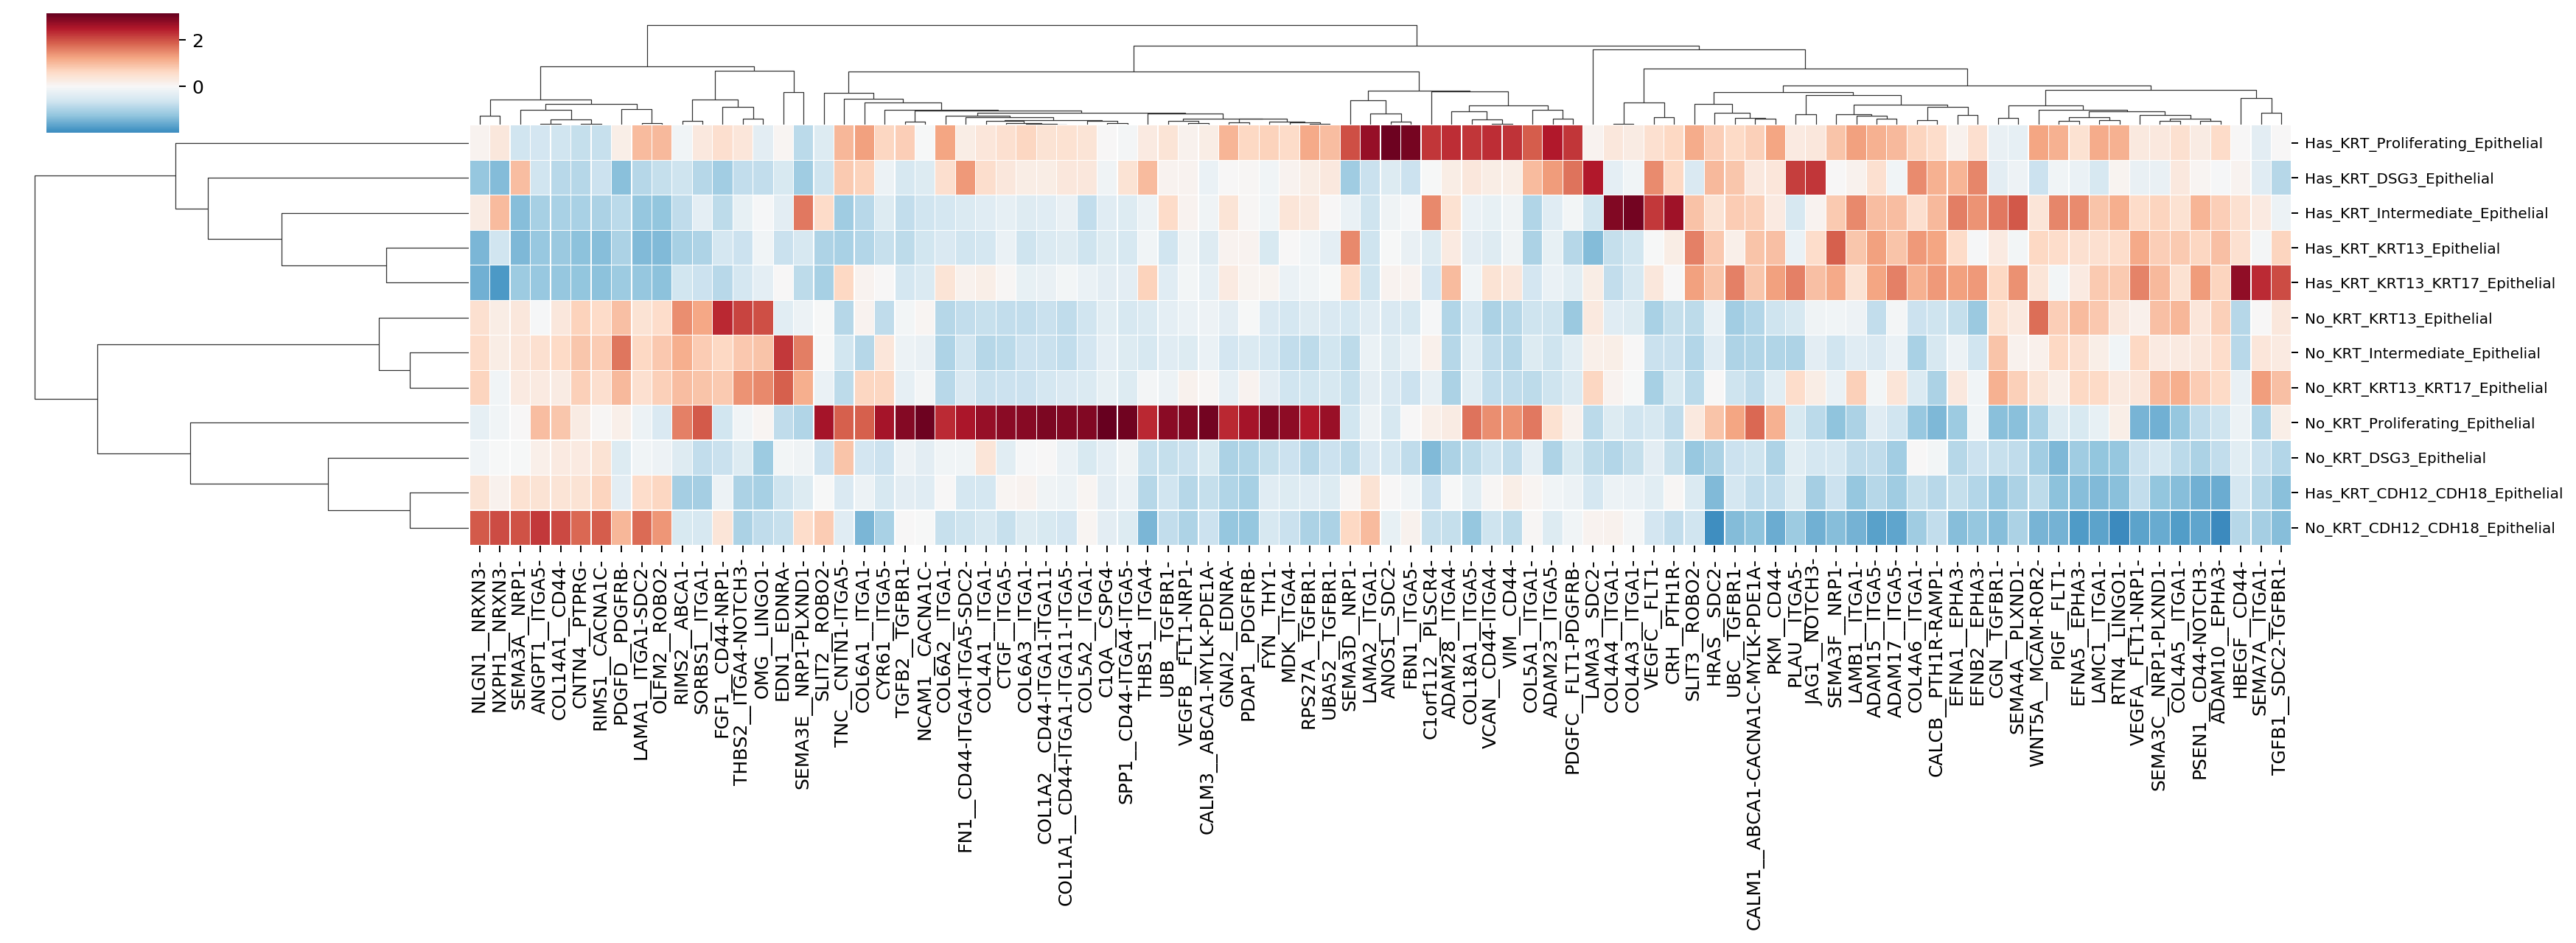

In [12]:
tick_labels = {}
for l in is_expressed:
    s = f'{l}__'
    for k, v in RL.items():
        if (l in v) and (k in top_receptors):
            s += f'{k}-'
    tick_labels[l] = s
    
scrna.plot_heatmap(gex[gex.obs['SubType_v2'].str.contains('Epithelial')], is_expressed, 'KRT_group_subtype', 
                   transpose=False, agg='mean', log=True, return_data=False, draw=True,
                   figsize=(20, 5),
                   z_score=1, cmap='RdBu_r', center_cmap=0,
                   replace_xticklabels=tick_labels
                  )

In [36]:
def is_expressed(foreground, background, significance_level=0.05, 
                 fallback_positive_cutoff=0.1, 
                 reps=1000,
                 expression_test='permutation',
                 verbose=False
                ):
    if foreground.shape[0] == 0:
        if verbose: print('is_expressed got foreground shape=0')
        return False
    
    if (background.shape[0] < foreground.shape[0]) or (expression_test == 'percent'):
        if verbose: print('is_expressed got small background population')
        # No background to compare, 10% test.
        # If any of the columns are non-zero at a certain rate, return True
        pct = (foreground > 0).mean(axis=0)
        return (pct > fallback_positive_cutoff).sum() > 0
    
    # We've covered the degenerate cases, do the real test
    # If multiple, test independently
    fg_mean = np.mean(foreground, axis=0)
    
    # Decide how many background points to sample
    # Usually sample the same size as foreground
    n_sample = foreground.shape[0]
    
    null_distrib = np.zeros((reps, background.shape[1]))
    for i in range(reps):
        idx = np.random.choice(background.shape[0], n_sample, replace=False)
        null_distrib[i, :] = np.mean(background[idx, :], axis=0)
        
    # Calculate enriched in foreground vs null-distribution
    q = np.quantile(null_distrib, 1-significance_level, axis=0)
    
        
    passing = fg_mean > q
    
    if verbose:
        with np.printoptions(suppress=True, precision=3):
            print('', fg_mean , '\nvs\n', q, '\n', passing)
    
    # Return true if any of the columns pass
    return passing.sum() > 0

    
def build_c_table(r_scores, gene_expr, obs, r_group, s_group, receptor, ligands, celltypes='SubType_v2', 
                  r_expression_test='permutation', 
                  l_expression_test='permutation', 
                  samples='Patient', verbose=False):
    """
    ctable is counting cases where each combination of the conditions are met:

                          ligand not-expressed | ligand expressed 
    --------------------------------------------------------------
    receptor not-active |                      |                 |
    --------------------------------------------------------------
    receptor active     |                      |                 |
    --------------------------------------------------------------

    receptor_active is receptor score in [population] > 95-th percentile of background scores for that receptor
    ligand-expressed is as ligand(s) expression in [population] > 95-th percentile of background expression for that receptor

    background expression is sampled from combinations of cells NOT in [population], taking samples to be the same
    number of cells as $N_{population}$

    Arguments:
    :param r_scores: anndata.AnnData object
    :param gene_expr: anndata.AnnData object
    :param obs: pandas.DataFrame - a common obs shared by r_scores and gene_expr
    :param r_group: string or list
    :param s_group: string or list
    :param receptor: string
    :param ligands: string or list
    :param celltypes: string
    :param samples: string
    """
    c_table = np.zeros((2,2), dtype=np.int) 
    
    r_scores = r_scores[:, r_scores.var_names == receptor]
    if not isinstance(ligands, list):
        ligands = [ligands]
        
    if not isinstance(r_group, list):
        r_group = [r_group]
        
    if not isinstance(s_group, list):
        s_group = [s_group]
        
    gene_expr = gene_expr[:, gene_expr.var_names.isin(ligands)]
    
    recv_idx = obs[celltypes].isin(r_group)
    send_idx = obs[celltypes].isin(s_group)
    
    if verbose: print(f'Checking for {ligands} --> {receptor} interactions ({s_group} --> {r_group})')
    u_samples = np.unique(obs[samples].values)
    for sample in u_samples:
        sample_idx = obs[samples].values == sample
        
        recv_r_score = r_scores[sample_idx & recv_idx].X.toarray()
        background_r_score = r_scores[sample_idx & ~recv_idx].X.toarray()
        
        send_gene_expr = gene_expr[sample_idx & send_idx].X.toarray()
        background_gene_expr = gene_expr[sample_idx & ~send_idx].X.toarray()
        
        if verbose:
            print()
            print(sample)
            print('recv_r_score', recv_r_score.shape, 'background', background_r_score.shape)
            print('send_gene_expr', send_gene_expr.shape, 'background', background_gene_expr.shape)
        
        # do expression of receiver
        if verbose: print('testing receptor expression')
        r_expressed = int(is_expressed(recv_r_score, background_r_score, expression_test=r_expression_test, verbose=verbose))
        if verbose: print('testing ligands expression')
        l_expressed = int(is_expressed(send_gene_expr, background_gene_expr, expression_test=l_expression_test, verbose=verbose))
        if verbose: print(r_expressed, l_expressed)
        
        c_table[r_expressed, l_expressed] += 1
        
    return c_table

In [15]:
# Reload scores
scores = sc.read_h5ad("receptor_genelists_2020_06_30_scores.h5ad")
print(scores.shape)

(67988, 675)


In [16]:
# group_receptors = dfs.loc[dfs['group'] == 'COL6_COL8_Fibroblast']['names'].values[:50]
# print(group_receptors)

In [40]:
senders = ['CDH12_CDH18_Epithelial', 'DSG3_Epithelial', 'KRT13_Epithelial', 
           'KRT13_KRT17_Epithelial', 'Proliferating_Epithelial', 'VEGF_Endothelial', 'FLT1_Endothelial']
receivers = ['PDPN_Fibroblast', 'PDGFRB_Fibroblast', 'FAP_Fibroblast',
             'ACTA2_Fibroblast']

import pandas as pd
import itertools
interactions = pd.DataFrame(index=senders, columns=receivers, dtype='object')
for s, r in itertools.product(senders, receivers):
    lst = []
    print(s, '-->', r)
    
    group_receptors = dfs.loc[dfs['group'] == r]['names'].values[:50]
    print(group_receptors)
    for i, receptor in enumerate(group_receptors):
        c_table = build_c_table(scores, gex, gex.obs, r, s, 
                                receptor, RL[receptor], 
                                celltypes='SubType_v2', 
                                samples='Patient', 
                                verbose=False)
        fisher_test_pval = fisher_exact(c_table, alternative='greater')[1]
        if fisher_test_pval < 0.05:
            print('\t', i, receptor, RL[receptor], f'{fisher_test_pval:3.3f}')
            lst.append(receptor)
            
    interactions.loc[s, r] = lst

CDH12_CDH18_Epithelial --> PDPN_Fibroblast
['TNFRSF21' 'F3' 'KREMEN1' 'CD96' 'ROBO2' 'KCND2' 'ERBB2' 'IL1R1' 'RYK'
 'ITGA6' 'ITGB6' 'CLDN4' 'TNFRSF1A' 'FGFR3' 'LPAR1' 'ITGB4' 'SLC44A5'
 'CD46' 'CLEC2D' 'RIPK1' 'LRP6' 'TMEM8A' 'MRC2' 'AXL' 'NOTCH3' 'NECTIN1'
 'LMBR1L' 'IL20RA' 'NECTIN3' 'SMAD3' 'TRAF3' 'EPHB6' 'PDGFRB' 'FLT1'
 'PTPRS' 'ITGA2' 'UNC5B' 'PTCH1' 'PLXNB2' 'IL4R' 'PDGFRA' 'ABCA1' 'PTPRA'
 'IFNAR1' 'ITGA3' 'STRA6' 'GFRA1' 'GPR39' 'NRP1' 'LRP4']
CDH12_CDH18_Epithelial --> PDGFRB_Fibroblast
['PDGFRB' 'NOTCH3' 'CDH6' 'ENPEP' 'TNFRSF21' 'PDE1A' 'FLT1' 'CD96' 'EDNRA'
 'ERBB2' 'SDC2' 'ITGA6' 'ITGB6' 'KREMEN1' 'IL20RA' 'CLDN4' 'ITGA3'
 'NECTIN1' 'FGFR3' 'RIPK1' 'RYK' 'KCND2' 'ITGB4' 'NRP1' 'TNFRSF1A' 'EPHB6'
 'SLC44A5' 'CD46' 'EPHA3' 'MCAM' 'TMEM8A' 'RXRA' 'AGR2' 'OCLN' 'EPHA2'
 'NECTIN3' 'PLXND1' 'GRIN2D' 'PLXNB2' 'PTPRA' 'DCBLD2' 'GPR39' 'PLXNA3'
 'INSR' 'CSPG4' 'IFNAR1' 'NOTCH1' 'PLXNA2' 'LMBR1L' 'PTPRG']
CDH12_CDH18_Epithelial --> FAP_Fibroblast
['NRP1' 'KCND2' 'TNFRSF21' 'ITGA6'

	 46 TNFRSF4 ['TNFSF4'] 0.040
Proliferating_Epithelial --> PDPN_Fibroblast
['TNFRSF21' 'F3' 'KREMEN1' 'CD96' 'ROBO2' 'KCND2' 'ERBB2' 'IL1R1' 'RYK'
 'ITGA6' 'ITGB6' 'CLDN4' 'TNFRSF1A' 'FGFR3' 'LPAR1' 'ITGB4' 'SLC44A5'
 'CD46' 'CLEC2D' 'RIPK1' 'LRP6' 'TMEM8A' 'MRC2' 'AXL' 'NOTCH3' 'NECTIN1'
 'LMBR1L' 'IL20RA' 'NECTIN3' 'SMAD3' 'TRAF3' 'EPHB6' 'PDGFRB' 'FLT1'
 'PTPRS' 'ITGA2' 'UNC5B' 'PTCH1' 'PLXNB2' 'IL4R' 'PDGFRA' 'ABCA1' 'PTPRA'
 'IFNAR1' 'ITGA3' 'STRA6' 'GFRA1' 'GPR39' 'NRP1' 'LRP4']
	 37 PTCH1 ['DHH', 'IHH', 'SHH'] 0.039
Proliferating_Epithelial --> PDGFRB_Fibroblast
['PDGFRB' 'NOTCH3' 'CDH6' 'ENPEP' 'TNFRSF21' 'PDE1A' 'FLT1' 'CD96' 'EDNRA'
 'ERBB2' 'SDC2' 'ITGA6' 'ITGB6' 'KREMEN1' 'IL20RA' 'CLDN4' 'ITGA3'
 'NECTIN1' 'FGFR3' 'RIPK1' 'RYK' 'KCND2' 'ITGB4' 'NRP1' 'TNFRSF1A' 'EPHB6'
 'SLC44A5' 'CD46' 'EPHA3' 'MCAM' 'TMEM8A' 'RXRA' 'AGR2' 'OCLN' 'EPHA2'
 'NECTIN3' 'PLXND1' 'GRIN2D' 'PLXNB2' 'PTPRA' 'DCBLD2' 'GPR39' 'PLXNA3'
 'INSR' 'CSPG4' 'IFNAR1' 'NOTCH1' 'PLXNA2' 'LMBR1L' 'PTPRG']
	 5

In [41]:
interactions

,PDPN_Fibroblast,PDGFRB_Fibroblast,FAP_Fibroblast,ACTA2_Fibroblast
CDH12_CDH18_Epithelial,[],[],[PLXNB2],[]
DSG3_Epithelial,[],[],[],[ITGA7]
KRT13_Epithelial,"[F3, ITGA2]","[FLT1, EPHA3]","[PDGFRB, RIPK1]",[]
KRT13_KRT17_Epithelial,"[IL1R1, AXL, PDGFRA, ABCA1]",[PLXND1],[CD46],[TNFRSF4]
Proliferating_Epithelial,[PTCH1],"[PDE1A, TNFRSF1A, MCAM]","[PTPRM, PTPRB]",[]
VEGF_Endothelial,"[F3, PDGFRB, UNC5B]","[PDGFRB, EPHA2, PTPRA]",[LMBR1L],[MYLK]
FLT1_Endothelial,"[LRP6, AXL, PDGFRB]","[PDGFRB, EDNRA, SDC2, RIPK1, EPHA3]",[],[]


In [38]:
interactions

,PDPN_Fibroblast,PDGFRB_Fibroblast,FAP_Fibroblast,ACTA2_Fibroblast
CDH12_CDH18_Epithelial,[],[],[PLXNB2],[]
DSG3_Epithelial,[],[],[],[ITGA7]
KRT13_Epithelial,"[F3, ITGA2]",[FLT1],[RIPK1],[]
KRT13_KRT17_Epithelial,"[IL1R1, UNC5B, PDGFRA, ABCA1, PTPRA]",[PLXND1],[CD46],[TNFRSF4]
Proliferating_Epithelial,[PTCH1],"[PDE1A, TNFRSF1A, MCAM, PLXND1]","[PTPRM, PTPRB]",[]


In [18]:
interactions

,PDPN_Fibroblast,PDGFRB_Fibroblast,FAP_Fibroblast,ACTA2_Fibroblast
CDH12_CDH18_Epithelial,[],[],[PLXNB2],[]
DSG3_Epithelial,[TMEM8A],[],[],[]
KRT13_Epithelial,"[F3, ROBO2, ITGA2]",[FLT1],[PDGFRB],[]
KRT13_KRT17_Epithelial,"[IL1R1, PDGFRA, ABCA1]","[PDE1A, PLXND1]",[CD46],[TNFRSF4]
Proliferating_Epithelial,[PTCH1],"[PDE1A, MCAM, AGR2, PLXND1]","[PTPRM, PTPRB]",[]


In [30]:
for s, r in itertools.product(senders, receivers):
    lst = []
    
    group_receptors = dfs.loc[dfs['group'] == r]['names'].values[:50]
    if 'EPHA3' in group_receptors:
        print(s, '-->', r)
        print(group_receptors)

CDH12_CDH18_Epithelial --> PDGFRB_Fibroblast
['PDGFRB' 'NOTCH3' 'CDH6' 'ENPEP' 'TNFRSF21' 'PDE1A' 'FLT1' 'CD96' 'EDNRA'
 'ERBB2' 'SDC2' 'ITGA6' 'ITGB6' 'KREMEN1' 'IL20RA' 'CLDN4' 'ITGA3'
 'NECTIN1' 'FGFR3' 'RIPK1' 'RYK' 'KCND2' 'ITGB4' 'NRP1' 'TNFRSF1A' 'EPHB6'
 'SLC44A5' 'CD46' 'EPHA3' 'MCAM' 'TMEM8A' 'RXRA' 'AGR2' 'OCLN' 'EPHA2'
 'NECTIN3' 'PLXND1' 'GRIN2D' 'PLXNB2' 'PTPRA' 'DCBLD2' 'GPR39' 'PLXNA3'
 'INSR' 'CSPG4' 'IFNAR1' 'NOTCH1' 'PLXNA2' 'LMBR1L' 'PTPRG']
DSG3_Epithelial --> PDGFRB_Fibroblast
['PDGFRB' 'NOTCH3' 'CDH6' 'ENPEP' 'TNFRSF21' 'PDE1A' 'FLT1' 'CD96' 'EDNRA'
 'ERBB2' 'SDC2' 'ITGA6' 'ITGB6' 'KREMEN1' 'IL20RA' 'CLDN4' 'ITGA3'
 'NECTIN1' 'FGFR3' 'RIPK1' 'RYK' 'KCND2' 'ITGB4' 'NRP1' 'TNFRSF1A' 'EPHB6'
 'SLC44A5' 'CD46' 'EPHA3' 'MCAM' 'TMEM8A' 'RXRA' 'AGR2' 'OCLN' 'EPHA2'
 'NECTIN3' 'PLXND1' 'GRIN2D' 'PLXNB2' 'PTPRA' 'DCBLD2' 'GPR39' 'PLXNA3'
 'INSR' 'CSPG4' 'IFNAR1' 'NOTCH1' 'PLXNA2' 'LMBR1L' 'PTPRG']
KRT13_Epithelial --> PDGFRB_Fibroblast
['PDGFRB' 'NOTCH3' 'CDH6' 'ENPEP' 'T

In [34]:
for s, r in itertools.product(senders, receivers):
    c_table = build_c_table(scores, gex, gex.obs, r, s,  
                            'EPHA3', RL['EPHA3'], celltypes='SubType_v2', 
                            r_expression_test='percent',
                            samples='Patient', verbose=False)
    print(s, r)
    print(c_table)
    print(fisher_exact(c_table, alternative='greater')[1])

CDH12_CDH18_Epithelial PDPN_Fibroblast
[[ 1  3]
 [11 10]]
0.9434782608695659
CDH12_CDH18_Epithelial PDGFRB_Fibroblast
[[ 1  4]
 [11  9]]
0.9757763975155296
CDH12_CDH18_Epithelial FAP_Fibroblast
[[3 5]
 [9 8]]
0.8750572082379869
CDH12_CDH18_Epithelial ACTA2_Fibroblast
[[ 7 11]
 [ 5  2]]
0.9733638443935928
DSG3_Epithelial PDPN_Fibroblast
[[ 2  2]
 [17  4]]
0.9687747035573121
DSG3_Epithelial PDGFRB_Fibroblast
[[ 3  2]
 [15  5]]
0.8869565217391306
DSG3_Epithelial FAP_Fibroblast
[[ 4  4]
 [13  4]]
0.9611446270485191
DSG3_Epithelial ACTA2_Fibroblast
[[14  4]
 [ 5  2]]
0.5565217391304349
KRT13_Epithelial PDPN_Fibroblast
[[ 1  3]
 [ 6 15]]
0.7581027667984193
KRT13_Epithelial PDGFRB_Fibroblast
[[ 1  4]
 [ 7 13]]
0.8835309617918329
KRT13_Epithelial FAP_Fibroblast
[[ 2  6]
 [ 6 11]]
0.8336740401728975
KRT13_Epithelial ACTA2_Fibroblast
[[ 4 14]
 [ 3  4]]
0.933638443935927
KRT13_KRT17_Epithelial PDPN_Fibroblast
[[ 2  2]
 [ 2 19]]
0.10632411067193677
KRT13_KRT17_Epithelial PDGFRB_Fibroblast
[[ 2  3]